# Preprocessing

1. Standardisation
2. Smoothing
3. Detrending (seasonality, polynomial trends, boosting)

In [166]:
from sktime.datasets import load_airline
from utils import load_pressure

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [167]:
def plot_y(y):
    fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
    ax.plot(y)
    return fig, ax

## Standardisation
* Box-Cox transformation
* Standard scaling 
* Min-max scaling

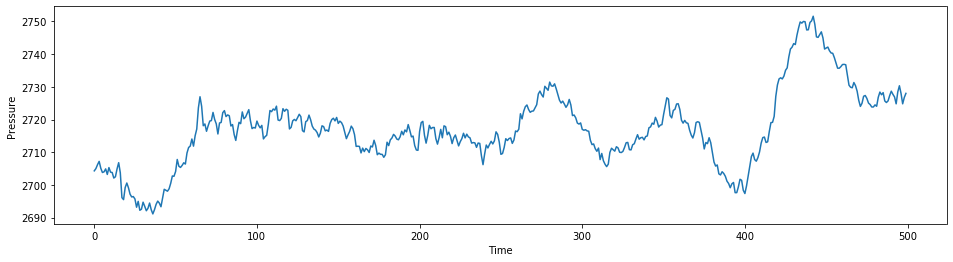

In [168]:
y = load_pressure()
fig, ax = plot_y(y)
ax.set(ylabel="Pressure", xlabel="Time");

In [169]:
from sktime.transformers.single_series.adapt import SingleSeriesTransformAdaptor
from sklearn.preprocessing import StandardScaler

In [170]:
scaler = SingleSeriesTransformAdaptor(StandardScaler())
yt = scaler.fit_transform(y)

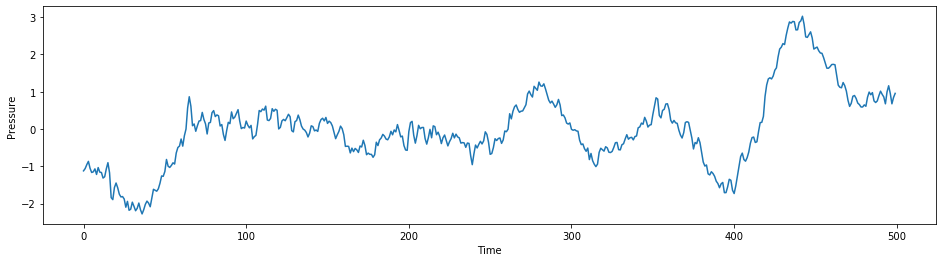

In [171]:
fig, ax = plot_y(yt)
ax.set(ylabel="Pressure", xlabel="Time");

When you have multiple series, each series has to be standardised separately. 

## Smoothing
* denoising
* [paper](https://arxiv.org/pdf/1811.00894.pdf) on smoothing for time series classification

### Discrete Fourier approximation
* Smoothing periodic signals
* Smooths the series by first transforming into the frequency domain, discarding the high frequency terms, then transforming back to the time domain

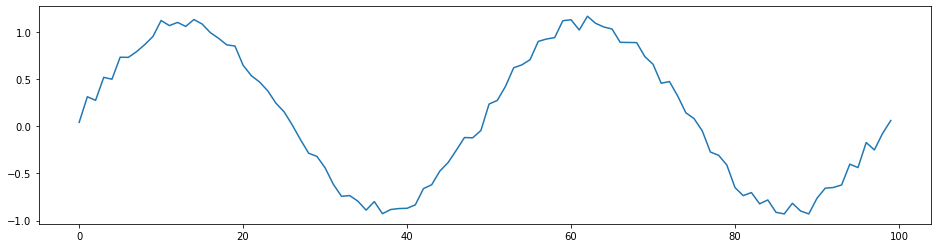

In [178]:
n_timepoints = 100
time_points = np.linspace(0, 4*np.pi, n_timepoints)
y = np.sin(time_points) + np.random.random(n_timepoints) * 0.2
plot_y(y);

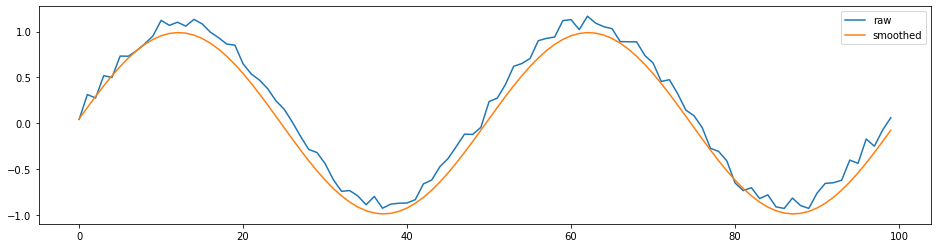

In [179]:
# fft
xt = np.fft.fft(y)
ps = xt.real ** 2 + xt.imag ** 2  # powerspectrum

# discard high frequencies
discarded_freq = ps < (ps.max() / 5)
xt[discarded_freq] = 0

# inverse fft
yt = np.fft.ifft(xt)

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
ax.plot(y, label="raw")
ax.plot(yt, label="smoothed")
plt.legend();

### Local polynomial approximation
* e.g. Savitzky-Golay filter which fits polynomial on successive windows by the method of linear least squares and smoothes the data by evaluating the fitted polynomial at the centre point of the window

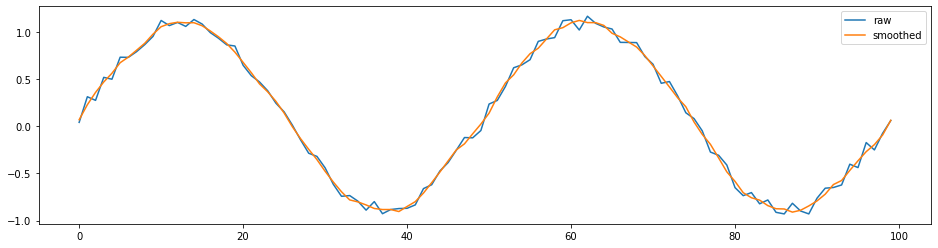

In [180]:
from scipy.signal import savgol_filter

degree = 3  # cubic
window_length = 7
yt = savgol_filter(y, window_length, degree)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
ax.plot(y, label="raw")
ax.plot(yt, label="smoothed")
plt.legend();

## Detrending

In [208]:
from sktime.transformers.single_series.detrend import Detrender
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.preprocessing import scale

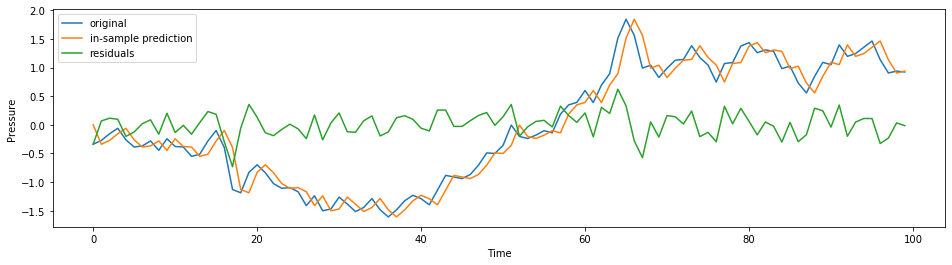

In [218]:
y = load_pressure().iloc[:100]
y = pd.Series(scale(y))  # standardise

forecaster = ExponentialSmoothing()
detrender = Detrender(forecaster)
yt = detrender.fit_transform(y)

forecaster.fit(y)
y_pred = forecaster.predict(fh=-np.arange(len(y)))

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
y.plot(ax=ax, label="original")
y_pred.plot(ax=ax, label="in-sample prediction")
yt.plot(ax=ax, label="residuals")
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();